In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

import visualize

import os
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
raw_data = pd.read_csv('data/train.csv')
X, y =  raw_data.drop('label', axis=1).values, raw_data.loc[:,'label'].values

In [3]:
X.shape

(60000, 784)

In [5]:
y.shape

(60000,)

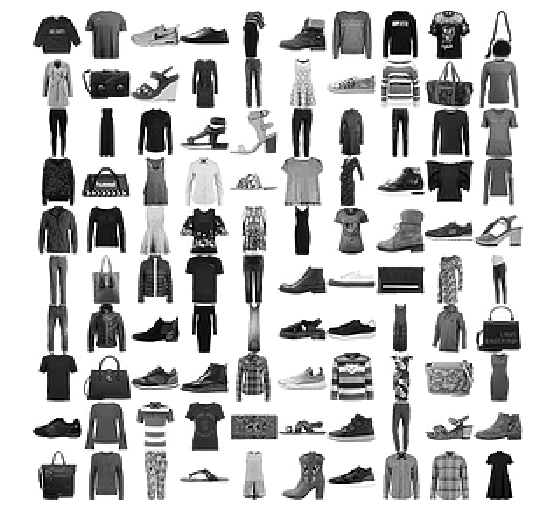

In [6]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
visualize.plot_items(example_images, images_per_row=10)
plt.show()

In [7]:
import clean_data
X_scaled = clean_data.num_pipeline(X)
X_reduced = clean_data.inc_pca(X_scaled)

/Users/jinli/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jinli/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
def train_algo (X, y, algo, cv=3, scoring="accuracy"):
    """
    Train given algorithms from scikit-learn,
    and evaluate it using cross validation.
    Return predictions of input X after the algorithm is trained.
    
    :param X: (instances, features)
    :type  X: numpy.ndarray
    :param y: Labels
    :type  y: pandas.core.series.Series
    :param algo: Algorithms from scikit-learn
    :type  algo:
    :param cv: The number of sets X is to be split to be cross validated.
    :type  cv: int
    :param scoring: Cross validation scoring type
    :type  scoring: str
    """
    start_time = time.time()
    algo_args = algo.fit(X, y)
    elapsed_time = time.time() - start_time
    print ("Train Time: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    print (algo_args, '\n')
    
    start_time = time.time()
    val_score = cross_val_score(algo, X, y, cv=cv, scoring=scoring)
    elapsed_time = time.time() - start_time
    print ("Cross Validation Score Time: " + 
           time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    print (val_score, '\n')
    
    start_time = time.time()
    y_pred = cross_val_predict(algo, X, y)
    elapsed_time = time.time() - start_time
    print ("Predict Time: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    return y_pred

In [9]:
# scoring types
f1 = 'f1_macro' # For classifiers
mse = 'neg_mean_squared_error'

def grid_search_param (X, y, model, param_grid, cv=5, scoring=f1):
    """
    Find the best parameters for a given model.
    
    :param model: Scikit-learn algorithms
    :type  model:
    :param para_grid: List of dictionaries. 
                      Each key is a parameter, 
                      each value is a list of parameter values to try.
    :type  para_grid: list
    :param cv: The number of sets X is to be split to be cross validated.
    :type  cv: int
    :param scoring: Evaluation type
    :type  scoring: str
    """
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring)
    grid_search.fit(X, y )
    return grid_search.best_params_

In [10]:
# Stochastic gradient descent classifier
# Default multiclass classifier: OvA
sgd_clf = SGDClassifier(random_state=42)
y_pred_sgd_clf = train_algo(X_reduced, y, sgd_clf)
y_pred_sgd_clf

Train Time: 00:00:02
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 

Cross Validation Score Time: 00:00:03
[0.82985 0.8251  0.82865] 

Predict Time: 00:00:02


array([8, 7, 6, ..., 8, 8, 7])

In [11]:
X_reduced.shape
y

array([2, 9, 6, ..., 8, 8, 7])

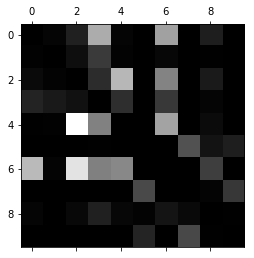

In [12]:
visualize.conf_mx_rates (y, y_pred_sgd_clf)

In [13]:
from sklearn.linear_model import LogisticRegression

# Hyperparameter C influences l2 regularization (ridge)
softmax_reg = LogisticRegression(
    multi_class='multinomial', 
    solver='lbfgs',
    C=5,
    tol=0.001,
    max_iter=200)

# Fails to converge
#y_pred_softmax_reg = train_algo(X_scaled, y, softmax_reg)

In [14]:
from sklearn.svm import LinearSVC
lin_svc = LinearSVC(C=1, loss='hinge')

# Fails to converge
#y_pred_lin_svc = train_algo(X_scaled, y, lin_svc)

In [15]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=10)

y_pred_tree_clf = train_algo(X_reduced, y, tree_clf)
y_pred_tree_clf

Train Time: 00:00:19
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Cross Validation Score Time: 00:00:36
[0.76495 0.76885 0.76955] 

Predict Time: 00:00:33


array([8, 9, 6, ..., 8, 8, 7])

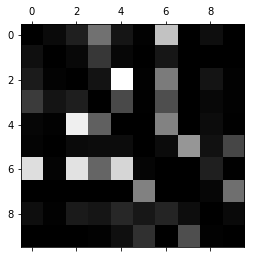

In [16]:
visualize.conf_mx_rates (y, y_pred_tree_clf)

In [17]:
from sklearn.ensemble import RandomForestClassifier

tree_param = [{
    'max_depth': [20, 25, 30], 
    'min_samples_leaf': [35, 40, 45],
    'max_leaf_nodes': [40, 45, 50], 
    'max_features': [25, 30, 35]
    }]

# If I wanted to do some grid search:
#tree_clf_best_param = grid_search_param (rnd_clf, tree_param, X_scaled, y)
#tree_clf_best_param

rnd_clf = RandomForestClassifier(n_estimators = 100, max_leaf_nodes=10, n_jobs=-1)

y_pred_rnd_clf = train_algo(X_reduced, y, rnd_clf)
y_pred_rnd_clf

Train Time: 00:00:21
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Cross Validation Score Time: 00:00:43
[0.72795 0.71805 0.72425] 

Predict Time: 00:00:38


array([8, 9, 4, ..., 8, 8, 7])